In [1]:
import tensorflow as tf
from matplotlib import pylab
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# Required for Data downaload and preparation
import struct
import gzip
import os
from six.moves.urllib.request import urlretrieve

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Defining Hyperparameters

Here we define the set of hyperparameters we're going to you in our example. These hyperparameters include `batch_size`, train dataset size (`n_train`), different layers in our CNN (`cnn_layer_ids`). You can find descriptions of each hyperparameter in comments.

In [2]:
batch_size = 100 # This is the typical batch size we've been using
image_size = 28 # This is the width/height of a single image

# Number of color channels in an image. These are black and white images 
n_channels = 1 

# Number of different digits we have images for (i.e. classes)
n_classes = 10

n_train = 55000 # Train dataset size
n_valid = 5000 # Validation dataset size
n_test = 10000 # Test dataset size

# Layers in the CNN in the order from input to output
cnn_layer_ids = ['conv1','pool1','conv2','pool2','fulcon1','softmax']

# Hyperparameters of each layer (e.g. filter size of each convolution layer)
layer_hyperparameters = {'conv1':{'weight_shape':[3,3,n_channels,16],'stride':[1,1,1,1],'padding':'SAME'},
                         'pool1':{'kernel_shape':[1,3,3,1],'stride':[1,2,2,1],'padding':'SAME'},
                         'conv2':{'weight_shape':[3,3,16,32],'stride':[1,1,1,1],'padding':'SAME'},
                         'pool2':{'kernel_shape':[1,3,3,1],'stride':[1,2,2,1],'padding':'SAME'},
                         'fulcon1':{'weight_shape':[7*7*32,128]},
                         'softmax':{'weight_shape':[128,n_classes]}
                        }

## Defining Inputs and Outputs
Here we define input and output placeholders required to process a batch of data. We will use the same placeholders for all training, validation and testing data as all of them are processed in same size batches.

In [3]:
# Inputs (Images) and Outputs (Labels) Placeholders
tf_inputs = tf.placeholder(shape=[batch_size, image_size, image_size, n_channels],dtype=tf.float32,name='tf_mnist_images')
tf_labels = tf.placeholder(shape=[batch_size, n_classes],dtype=tf.float32,name='tf_mnist_labels')

## Defining Model Parameters and Other Variables
Here we define various TensorFlow variables required for the following computations. These includes a global step variable (to decay learning rate) and weights and biases of each layer of the CNN.

In [4]:
# Global step for decaying the learning rate
global_step = tf.Variable(0,trainable=False)

# Initializing the variables
layer_weights = {}
layer_biases = {}

for layer_id in cnn_layer_ids:
    if 'pool' not in layer_id:
        layer_weights[layer_id] = tf.Variable(initial_value=tf.random_normal(shape=layer_hyperparameters[layer_id]['weight_shape'],
                                                                          stddev=0.02,dtype=tf.float32),name=layer_id+'_weights')
        layer_biases[layer_id] = tf.Variable(initial_value=tf.random_normal(shape=[layer_hyperparameters[layer_id]['weight_shape'][-1]],
                                                                              stddev=0.01,dtype=tf.float32),name=layer_id+'_bias')
    
print('Variables initialized')

Variables initialized


## Defining Inference of the CNN
Here we define the computations starting from input placeholder (`tf_inputs`) and then computing the hidden activations for each of the layers found in `cnn_layer_ids` (i.e. convolution/pooling and fulcon layers) and their respective parameters (`layer_hyperparamters`). At the final layer (`softmax`) we do not apply an activation function as for the rest of the layers, but obtain the unnormalized logit values without any activation function.

In [5]:
# Calculating Logits

h = tf_inputs
for layer_id in cnn_layer_ids:
    if 'conv' in layer_id:
        # For each convolution layer, compute the output by using conv2d function
        # This operation results in a [batch_size, output_height, output_width, out_channels]
        # sized 4 dimensional tensor
        h = tf.nn.conv2d(h,layer_weights[layer_id],layer_hyperparameters[layer_id]['stride'], 
                         layer_hyperparameters[layer_id]['padding']) + layer_biases[layer_id]
        h = tf.nn.relu(h)

    elif 'pool' in layer_id:
        # For each pooling layer, compute the output by max pooling
        # This operation results in a [batch_size, output_height, output_width, out_channels]
        # sized 4 dimensional tensor
        h = tf.nn.max_pool(h, layer_hyperparameters[layer_id]['kernel_shape'],layer_hyperparameters[layer_id]['stride'],
                          layer_hyperparameters[layer_id]['padding'])

    elif layer_id == 'fulcon1':
        # At the first fulcon layer we need to reshape the 4 dimensional output to a
        # 2 dimensional output to be processed by fully connected layers
        # Note this should only done once, before 
        # computing the output of the first fulcon layer
        h = tf.reshape(h,[batch_size,-1])
        h = tf.matmul(h,layer_weights[layer_id]) + layer_biases[layer_id]
        h = tf.nn.relu(h)

    elif layer_id == 'softmax':
        # Note that here we do not perform the same reshaping we did for fulcon1
        # We only perform the matrix multiplication on previous output
        h = tf.matmul(h,layer_weights[layer_id]) + layer_biases[layer_id]

print('Calculated logits')
tf_logits = h

Calculated logits


## Defining Loss
We use softmax cross entropy loss to optimize the parameters of the model.

In [6]:
# Calculating the softmax cross entropy loss with the computed logits and true labels (one hot encoded)
tf_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf_logits,labels=tf_labels)
print('Loss defined')

Loss defined


## Model Parameter Optimizer
We define an exponentially decaying learning rate and an optimizer to optimize the parameters.

In [7]:
# Optimization

# Here we define the function to decay the learning rate exponentially. 
# Everytime the global step increases the learning rate decreases
tf_learning_rate = tf.train.exponential_decay(learning_rate=0.001,global_step=global_step,decay_rate=0.5,decay_steps=1,staircase=True)
tf_loss_minimize = tf.train.RMSPropOptimizer(learning_rate=tf_learning_rate, momentum=0.9).minimize(tf_loss)
print('Loss minimization defined')

Loss minimization defined


## Defining Predictions
We get the predictiosn out by applying a softmax activation to the logits. Additionally we define a global step increment function and will be increase every time the validation accuracy plateus.

In [8]:
tf_predictions = tf.nn.softmax(tf_logits)
print('Prediction defined')

tf_tic_toc = tf.assign(global_step, global_step + 1)


Prediction defined


## Define Accuracy 
A simple function to calculate accuracy for a given set of labels and predictions.

In [9]:
def accuracy(predictions,labels):
    '''
    Accuracy of a given set of predictions of size (N x n_classes) and
    labels of size (N x n_classes)
    '''
        
    return np.sum(np.argmax(predictions,axis=1)==np.argmax(labels,axis=1))*100.0/labels.shape[0]

## Lolading Data

Here we download (if needed) the MNIST dataset and, perform reshaping and normalization. Also we conver the labels to one hot encoded vectors.

In [42]:
def maybe_download(url, filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename


def read_mnist(fname_img, fname_lbl, one_hot=False):
    print('\nReading files %s and %s'%(fname_img, fname_lbl))
    
    # Processing images
    with gzip.open(fname_img) as fimg:        
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        print(num,rows,cols)
        img = (np.frombuffer(fimg.read(num*rows*cols), dtype=np.uint8).reshape(num, rows, cols,1)).astype(np.float32)
        print('(Images) Returned a tensor of shape ',img.shape)
        
        #img = (img - np.mean(img)) /np.std(img)
        img *= 1.0 / 255.0
    
    # Processing labels
    with gzip.open(fname_lbl) as flbl:
        # flbl.read(8) reads upto 8 bytes
        magic, num = struct.unpack(">II", flbl.read(8))               
        lbl = np.frombuffer(flbl.read(num), dtype=np.int8)
        if one_hot:
            one_hot_lbl = np.zeros(shape=(num,10),dtype=np.float32)
            one_hot_lbl[np.arange(num),lbl] = 1.0
        print('(Labels) Returned a tensor of shape: %s'%lbl.shape)
        print('Sample labels: ',lbl[:10])
    
    if not one_hot:
        return img, lbl
    else:
        return img, one_hot_lbl
    
    
# Download data if needed
url = 'http://yann.lecun.com/exdb/mnist/'
# training data
maybe_download(url,'train-images-idx3-ubyte.gz',9912422)
maybe_download(url,'train-labels-idx1-ubyte.gz',28881)
# testing data
maybe_download(url,'t10k-images-idx3-ubyte.gz',1648877)
maybe_download(url,'t10k-labels-idx1-ubyte.gz',4542)

# Read the training and testing data 
train_inputs, train_labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',True)
test_inputs, test_labels = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz',True)

valid_inputs, valid_labels = train_inputs[-n_valid:,:,:,:], train_labels[-n_valid:,:]
train_inputs, train_labels = train_inputs[:-n_valid,:,:,:], train_labels[:-n_valid,:]

print('\nTrain size: ', train_inputs.shape[0])
print('\nValid size: ', valid_inputs.shape[0])
print('\nTest size: ', test_inputs.shape[0])

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz

Reading files train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz
60000 28 28
(Images) Returned a tensor of shape  (60000, 28, 28, 1)
(Labels) Returned a tensor of shape: 60000
Sample labels:  [5 0 4 1 9 2 1 3 1 4]

Reading files t10k-images-idx3-ubyte.gz and t10k-labels-idx1-ubyte.gz
10000 28 28
(Images) Returned a tensor of shape  (10000, 28, 28, 1)
(Labels) Returned a tensor of shape: 10000
Sample labels:  [7 2 1 0 4 1 4 9 5 9]

Train size:  55000

Valid size:  5000

Test size:  10000


## Data Generators for MNIST

Here we have the logic to iterate through each training, validation and testing datasets, in `batch_size` size strides.

In [71]:
train_index, valid_index, test_index = 0,0,0

def get_train_batch(images, labels, batch_size):
    global train_index
    batch = images[train_index:train_index+batch_size,:,:,:], labels[train_index:train_index+batch_size,:]
    train_index = (train_index + batch_size)%(images.shape[0] - batch_size)
    return batch

def get_valid_batch(images, labels, batch_size):
    global valid_index
    batch = images[valid_index:valid_index+batch_size,:,:,:], labels[valid_index:valid_index+batch_size,:]
    valid_index = (valid_index + batch_size)%(images.shape[0] - batch_size)
    return batch

def get_test_batch(images, labels, batch_size):
    global test_index
    batch = images[test_index:test_index+batch_size,:,:,:], labels[test_index:test_index+batch_size,:]
    test_index = (test_index + batch_size)%(images.shape[0] - batch_size)
    return batch

## Visualizing MNIST Results
Here we define a function to collect correctly and incorrectly classified samples to visualize later. Visualizing such samples will help us to understand why the CNN incorrectly classified certain samples.

In [74]:
# Makes sure we only collect 10 samples for each 
correct_fill_index, incorrect_fill_index = 0,0

# Visualization purposes
correctly_predicted = np.empty(shape=(10,28,28,1),dtype=np.float32)
correct_predictions = np.empty(shape=(10,n_classes),dtype=np.float32)
incorrectly_predicted = np.empty(shape=(10,28,28,1),dtype=np.float32)
incorrect_predictions = np.empty(shape=(10,n_classes),dtype=np.float32)

def collect_samples(test_batch_predictions,test_images, test_labels):
    global correctly_predicted, correct_predictions
    global incorrectly_predicted, incorrect_predictions
    global correct_fill_index, incorrect_fill_index
    
    correct_indices = np.where(np.argmax(test_batch_predictions,axis=1)==np.argmax(test_labels,axis=1))[0]
    incorrect_indices = np.where(np.argmax(test_batch_predictions,axis=1)!=np.argmax(test_labels,axis=1))[0]
    
    if correct_indices.size>0 and correct_fill_index<10:
        print('\nCollecting Correctly Predicted Samples')
        chosen_index = np.random.choice(correct_indices)
        correctly_predicted[correct_fill_index,:,:,:]=test_images[chosen_index,:].reshape(1,image_size,image_size,n_channels)
        correct_predictions[correct_fill_index,:]=test_batch_predictions[chosen_index,:]
        correct_fill_index += 1

    if incorrect_indices.size>0 and incorrect_fill_index<10:
        print('Collecting InCorrectly Predicted Samples')
        chosen_index = np.random.choice(incorrect_indices)
        incorrectly_predicted[incorrect_fill_index,:,:,:]=test_images[chosen_index,:].reshape(1,image_size,image_size,n_channels)
        incorrect_predictions[incorrect_fill_index,:]=test_batch_predictions[chosen_index,:]
        incorrect_fill_index += 1

## Running MNIST Classification 
Here we train our CNN on MNIST data for `n_epochs` epochs. Each epoch we train the CNN with the full training dataset. Then we calculate the validation accuracy, according to which we decay the learning rate. Finally, each epoch we calculate the test accuracy which is computed using an independent test set. This code should run under 10 minutes if you run on a decent GPU and should reach to a test accuracy of about ~95%

In [75]:
# Parameters related to learning rate decay
# counts how many times the validation accuracy has not increased consecutively for
v_acc_not_increased_for = 0 
# if the above count is above this value, decrease the learning rate
v_acc_threshold = 3
# currently recorded best validation accuracy
max_v_acc = 0.0

config = tf.ConfigProto(allow_soft_placement=True)
# Good practice to use this to avoid any surprising errors thrown by TensorFlow
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # Making sure Tensorflow doesn't overflow the GPU

n_epochs = 25 # Number of epochs the training runs for

session = tf.InteractiveSession(config=config)
# Initialize all variables
tf.global_variables_initializer().run()

# Run training loop

for epoch in range(n_epochs):
    loss_per_epoch = []
    
    # Training phase. We train with all training data 
    # processing one batch at a time
    for i in range(n_train//batch_size):
        # Get the next batch of MNIST dataset
        batch = get_train_batch(train_inputs, train_labels, batch_size)   
        # Run TensorFlow opeartions
        l,_ = session.run([tf_loss,tf_loss_minimize],feed_dict={tf_inputs: batch[0].reshape(batch_size,image_size,image_size,n_channels),
                                  tf_labels: batch[1]})
        # Add the loss value to a list
        loss_per_epoch.append(l)
    print('Average loss in epoch %d: %.5f'%(epoch,np.mean(loss_per_epoch)))    
    
    # Validation phase. We compute validation accuracy
    # processing one batch at a time
    valid_accuracy_per_epoch = []
    for i in range(n_valid//batch_size):
        # Get the next validation data batch
        vbatch_images,vbatch_labels = get_valid_batch(valid_inputs, valid_labels, batch_size)
        # Compute validation predictions
        valid_batch_predictions = session.run(
            tf_predictions,feed_dict={tf_inputs: vbatch_images}
        )
        # Compute and add the validation accuracy to a python list
        valid_accuracy_per_epoch.append(accuracy(valid_batch_predictions,vbatch_labels))
    
    # Compute and print average validation accuracy
    mean_v_acc = np.mean(valid_accuracy_per_epoch)
    print('\tAverage Valid Accuracy in epoch %d: %.5f'%(epoch,np.mean(valid_accuracy_per_epoch)))
    
    # Learning rate decay logic
    if mean_v_acc > max_v_acc:
        max_v_acc = mean_v_acc
    else:
        v_acc_not_increased_for += 1
    
    # Time to decrease learning rate
    if v_acc_not_increased_for >= v_acc_threshold:
        print('\nDecreasing Learning rate\n')
        session.run(tf_tic_toc) # Increase global_step
        v_acc_not_increased_for = 0
        
    # Testing phase. We compute test accuracy
    # processing one batch at a time
    accuracy_per_epoch = []
    for i in range(n_test//batch_size):
        btest_images, btest_labels = get_test_batch(test_inputs, test_labels, batch_size)
        test_batch_predictions = session.run(tf_predictions,feed_dict={tf_inputs: btest_images})
        accuracy_per_epoch.append(accuracy(test_batch_predictions,btest_labels))
        
        # Collect samples for visualization only in the last epoch
        if epoch==n_epochs-1:
            collect_samples(test_batch_predictions, btest_images, btest_labels)
        
    print('\tAverage Test Accuracy in epoch %d: %.5f\n'%(epoch,np.mean(accuracy_per_epoch)))
session.close()

c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Average loss in epoch 0: 0.36967
	Average Valid Accuracy in epoch 0: 98.00000
	Average Test Accuracy in epoch 0: 97.84000

Average loss in epoch 1: 0.08493
	Average Valid Accuracy in epoch 1: 97.62000
	Average Test Accuracy in epoch 1: 97.26000

Average loss in epoch 2: 0.07174
	Average Valid Accuracy in epoch 2: 98.40000
	Average Test Accuracy in epoch 2: 97.97000

Average loss in epoch 3: 0.06057
	Average Valid Accuracy in epoch 3: 98.56000
	Average Test Accuracy in epoch 3: 98.40000

Average loss in epoch 4: 0.05895
	Average Valid Accuracy in epoch 4: 98.30000
	Average Test Accuracy in epoch 4: 98.17000

Average loss in epoch 5: 0.05891
	Average Valid Accuracy in epoch 5: 98.58000
	Average Test Accuracy in epoch 5: 98.42000

Average loss in epoch 6: 0.06474
	Average Valid Accuracy in epoch 6: 98.52000

Decreasing Learning rate

	Average Test Accuracy in epoch 6: 98.27000

Average loss in epoch 7: 0.03413
	Average Valid Accuracy in epoch 7: 98.72000
	Average Test Accuracy in epoch 7:

## Visualizing Predictions
Let us see how when our CNN did when it comes to predictions


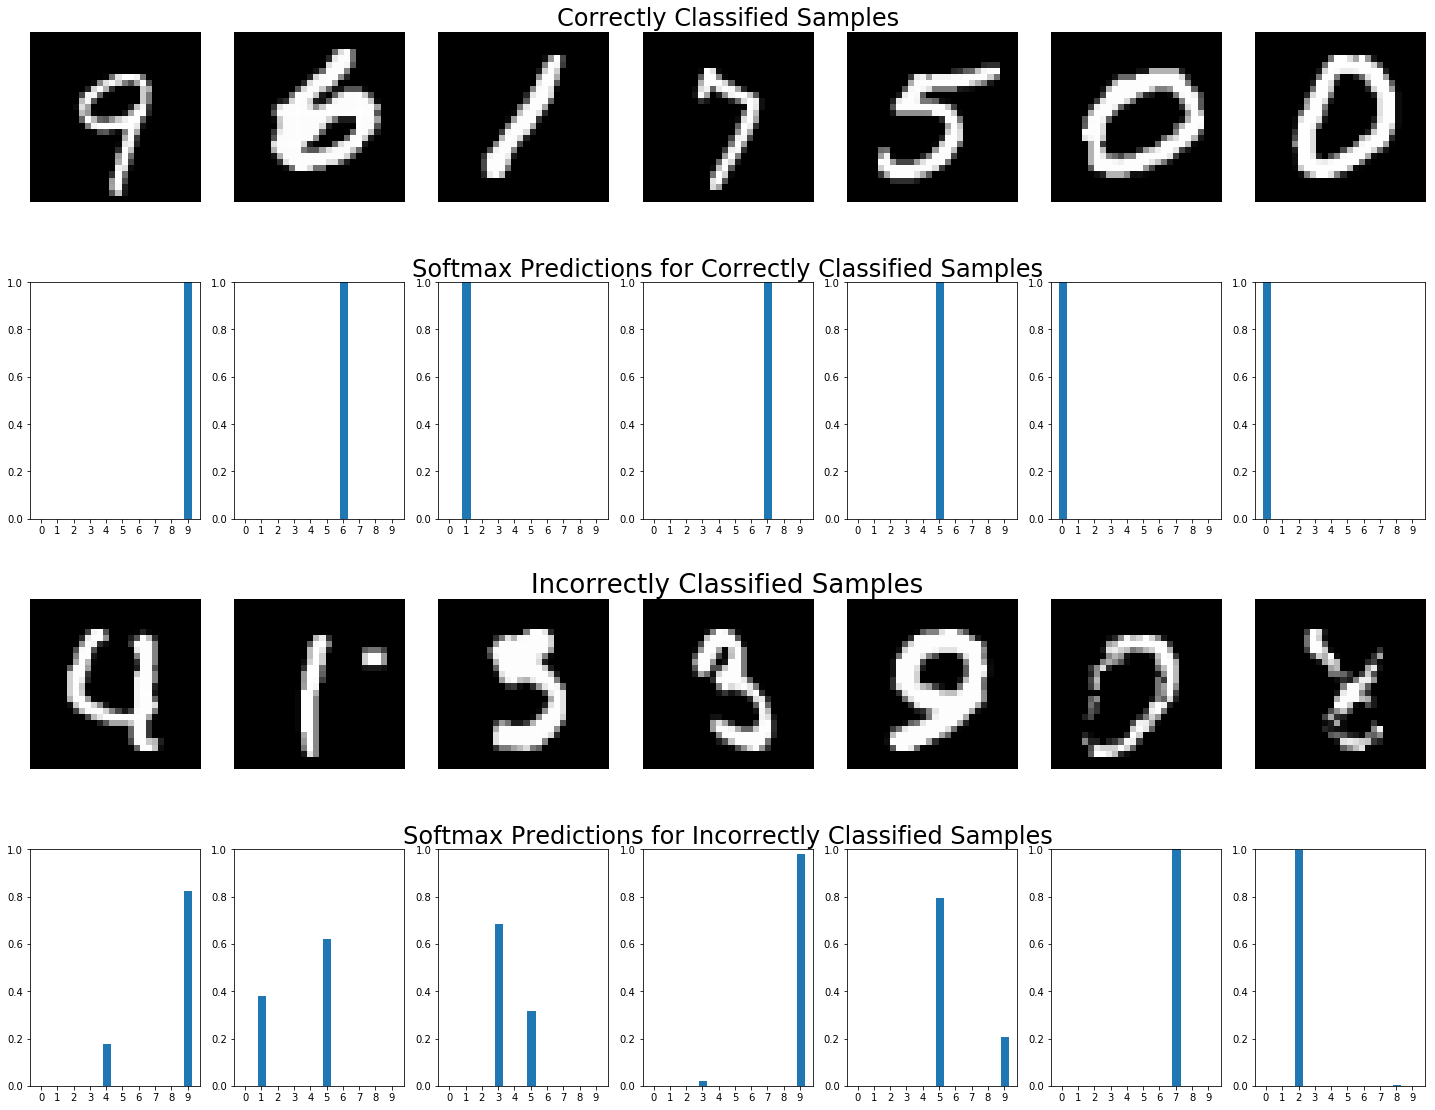

In [76]:
# Defining the plot related settings
pylab.figure(figsize=(25,20))  # in inches
width=0.5 # Width of a bar in the barchart
padding = 0.05 # Padding between two bars
labels = list(range(0,10)) # Class labels

# Defining X axis
x_axis = np.arange(0,10)

# We create 4 rows and 7 column set of subplots

# We choose these to put the titles in
# First row middle
pylab.subplot(4, 7, 4)
pylab.title('Correctly Classified Samples',fontsize=24)

# Second row middle
pylab.subplot(4, 7,11)
pylab.title('Softmax Predictions for Correctly Classified Samples',fontsize=24)

# For 7 steps
for sub_i in range(7):
    # Draw the top row (digit images)
    pylab.subplot(4, 7, sub_i + 1)        
    pylab.imshow(np.squeeze(correctly_predicted[sub_i]),cmap='gray')    
    pylab.axis('off')
    
    # Draw the second row (prediction bar chart)
    pylab.subplot(4, 7, 7 + sub_i + 1)        
    pylab.bar(x_axis + padding, correct_predictions[sub_i], width)
    pylab.ylim([0.0,1.0])    
    pylab.xticks(x_axis, labels)

# Set titles for the third and fourth rows
pylab.subplot(4, 7, 18)
pylab.title('Incorrectly Classified Samples',fontsize=26)
pylab.subplot(4, 7,25)
pylab.title('Softmax Predictions for Incorrectly Classified Samples',fontsize=24)

# For 7 steps
for sub_i in range(7):
    # Draw the third row (incorrectly classified digit images)
    pylab.subplot(4, 7, 14 + sub_i + 1)
    pylab.imshow(np.squeeze(incorrectly_predicted[sub_i]),cmap='gray')
    pylab.axis('off')
    
    # Draw the fourth row (incorrect predictions bar chart)
    pylab.subplot(4, 7, 21 + sub_i + 1)        
    pylab.bar(x_axis + padding, incorrect_predictions[sub_i], width)
    pylab.ylim([0.0,1.0])
    pylab.xticks(x_axis, labels)

# Save the figure
pylab.savefig('mnist_results.png')
pylab.show()
